In [11]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Disable logs
tf.get_logger().setLevel('ERROR')

# Fetch dataset
train_ds: tf.data.Dataset
test_ds: tf.data.Dataset

(train_ds, test_ds), info = tfds.load('caltech_birds2011', split=['train', 'test'], 
                                      batch_size=64, as_supervised=True, shuffle_files=True, with_info=True)

# Prepear dataset
def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        128, 128,
        method='bilinear',
        antialias=False,
    )
    
    return image, label

train_ds = (
    train_ds
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

num_classes = info.features['label'].num_classes

# Display dataset info
print("Train: {}, test: {}".format(len(train_ds), len(test_ds)))
print("Number of classes: {}".format(num_classes))

Train: 94, test: 91
Number of classes: 200


In [12]:
from tensorflow import keras
from keras import layers

# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=[128, 128, 3]),
    layers.Rescaling(scale=1./255),

    # Data augmentation
    layers.RandomContrast(factor=0.10),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),

    # Block 1
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=4, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=4, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block 3
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=4, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=4, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes),
])

# Summarize model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_contrast_4 (RandomCo  (None, 128, 128, 3)      0         
 ntrast)                                                         
                                                                 
 random_flip_4 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 128, 128, 3)      0         
 tation)                                                         
                                                                 
 batch_normalization_16 (Bat  (None, 128, 128, 3)      21        
 chNormalization)                                                
                                                      

In [13]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
)

# Save model
model.save("output/m2")

Epoch 1/10
94/94 [==============================] - 46s 411ms/step - loss: 5.3562 - accuracy: 0.0030 - val_loss: 5.2983 - val_accuracy: 0.0052
Epoch 2/10
94/94 [==============================] - 33s 352ms/step - loss: 5.6755 - accuracy: 0.0038 - val_loss: 5.3110 - val_accuracy: 0.0052
Epoch 3/10
94/94 [==============================] - 33s 352ms/step - loss: 7.8957 - accuracy: 0.0038 - val_loss: 5.2985 - val_accuracy: 0.0050
Epoch 4/10
94/94 [==============================] - 33s 353ms/step - loss: 7.7905 - accuracy: 0.0052 - val_loss: 5.2984 - val_accuracy: 0.0052
Epoch 5/10
94/94 [==============================] - 33s 351ms/step - loss: 68.7918 - accuracy: 0.0030 - val_loss: 7.0103 - val_accuracy: 0.0041
Epoch 6/10
94/94 [==============================] - 33s 353ms/step - loss: 40.1181 - accuracy: 0.0040 - val_loss: 5.3024 - val_accuracy: 0.0052
Epoch 7/10
94/94 [==============================] - 33s 351ms/step - loss: 25.5747 - accuracy: 0.0045 - val_loss: 5.2984 - val_accuracy: 0.0

<AxesSubplot: >

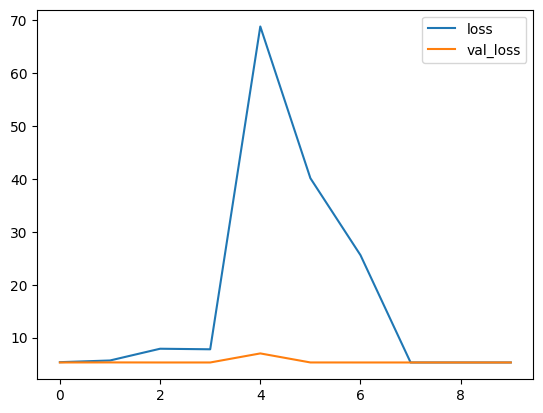

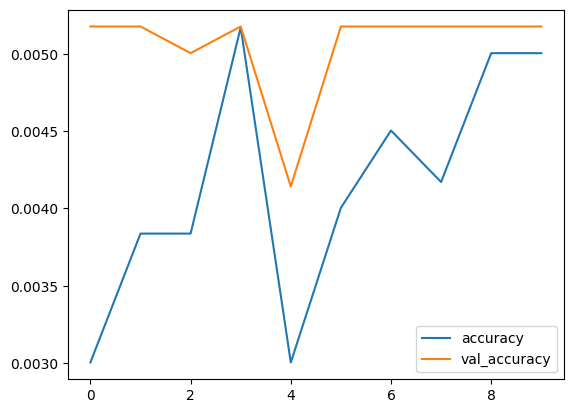

In [14]:
# Plot learning curves
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()